# Testing the Model

Import necessary libraries

In [3]:

import csv
import requests

# Define the CSV file paths
csv_file = './image_data_with_paths.csv'
updated_csv_file = './image_data_with_results.csv'

# Define the API endpoint URL for face comparison
api_url = 'http://127.0.0.1:5000/compare'


Define a function to send the images to the server and return the result


In [5]:
def compare_faces(img_1_path, img_2_path):
    try:
        # Open the image files
        with open(img_1_path, 'rb') as img_1, open(img_2_path, 'rb') as img_2:
            # Send the POST request with image files
            response = requests.post(api_url, files={'reference_image': img_1, 'live_image': img_2})
        
        # If the request was successful (HTTP 200)
        if response.status_code == 200:
            # Extract the 'identical' result from the JSON response
            result = response.json().get('identical', None)
            return result
        else:
            return 'Error'  # If not 200, return 'Error'

    except Exception as e:
        # Handle any exceptions (file not found, connection issues, etc.)
        return f'Error: {e}'

Open the original CSV file, process the data and perform the Test

In [6]:
with open(csv_file, mode='r', newline='') as infile, open(updated_csv_file, mode='w', newline='') as outfile:
    reader = csv.DictReader(infile)
    fieldnames = reader.fieldnames  # Keep the original column headers
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)

    # Write the headers to the output CSV
    writer.writeheader()

    # Iterate through each row of the CSV
    for row in reader:
        img_1_path = row['img_1_path']
        img_2_path = row['img_2_path']

        # Compare the faces and get the result
        result = compare_faces(img_1_path, img_2_path)

        # Update the 'result' column in the row
        row['result'] = result

        # Write the updated row to the output CSV
        writer.writerow(row)

print(f"Updated CSV file saved as {updated_csv_file}.")

Updated CSV file saved as ./image_data_with_results.csv.


# Analysis of Generated Test Result


Import necessary libraries


In [8]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
csv_file = 'image_data_with_results.csv'
df = pd.read_csv(csv_file)

# Display the first few rows of the dataframe
df.head()


,label,img-1,img-2,img_1_path,img_2_path,actual_result,result
0,Dwayne Johnson,Dwayne Johnson_44.jpg,Akshay Kumar_37.jpg,./Images/Dwayne Johnson/Dwayne Johnson_44.jpg,./Images/Akshay Kumar/Akshay Kumar_37.jpg,False,False
1,Dwayne Johnson,Dwayne Johnson_45.jpg,Kashyap_10.jpg,./Images/Dwayne Johnson/Dwayne Johnson_45.jpg,./Images/Kashyap/Kashyap_10.jpg,False,False
2,Camila Cabello,Camila Cabello_39.jpg,Zac Efron_44.jpg,./Images/Camila Cabello/Camila Cabello_39.jpg,./Images/Zac Efron/Zac Efron_44.jpg,False,False
3,Dwayne Johnson,Dwayne Johnson_31.jpg,Virat Kohli_32.jpg,./Images/Dwayne Johnson/Dwayne Johnson_31.jpg,./Images/Virat Kohli/Virat Kohli_32.jpg,False,False
4,Alia Bhatt,Alia Bhatt_39.jpg,Henry Cavill_19.jpg,./Images/Alia Bhatt/Alia Bhatt_39.jpg,./Images/Henry Cavill/Henry Cavill_19.jpg,False,False


Data Preprocessing - Mapping result column to numerical values

In [13]:
# Map the results into numerical values
df['mapped_result'] = df['result'].map({
    True: 1, 
    False: 0, 
    'Comparison Failed': -1  # Handle 'Comparison Failed' separately
})

# Map the actual results into numerical values
df['mapped_actual'] = df['actual_result'].map({True: 1, False: 0})

# Filter out the 'Comparison Failed' cases as these are non-comparable for performance metrics
filtered_df = df[df['mapped_result'] != -1]

# Show the filtered dataframe
filtered_df.head()


,label,img-1,img-2,img_1_path,img_2_path,actual_result,result,mapped_result,mapped_actual
0,Dwayne Johnson,Dwayne Johnson_44.jpg,Akshay Kumar_37.jpg,./Images/Dwayne Johnson/Dwayne Johnson_44.jpg,./Images/Akshay Kumar/Akshay Kumar_37.jpg,False,False,0,0
1,Dwayne Johnson,Dwayne Johnson_45.jpg,Kashyap_10.jpg,./Images/Dwayne Johnson/Dwayne Johnson_45.jpg,./Images/Kashyap/Kashyap_10.jpg,False,False,0,0
2,Camila Cabello,Camila Cabello_39.jpg,Zac Efron_44.jpg,./Images/Camila Cabello/Camila Cabello_39.jpg,./Images/Zac Efron/Zac Efron_44.jpg,False,False,0,0
3,Dwayne Johnson,Dwayne Johnson_31.jpg,Virat Kohli_32.jpg,./Images/Dwayne Johnson/Dwayne Johnson_31.jpg,./Images/Virat Kohli/Virat Kohli_32.jpg,False,False,0,0
4,Alia Bhatt,Alia Bhatt_39.jpg,Henry Cavill_19.jpg,./Images/Alia Bhatt/Alia Bhatt_39.jpg,./Images/Henry Cavill/Henry Cavill_19.jpg,False,False,0,0


Performance Metrics Calculation

In [14]:
# Check the size of filtered_df
if filtered_df.empty:
    print("No valid data for analysis. All rows might be 'Comparison Failed'.")
else:
    # Proceed with confusion matrix calculation and visualization
    y_true = filtered_df['mapped_actual']
    y_pred = filtered_df['mapped_result']

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Calculate the performance metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Display the Performance metrics
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')


Accuracy: 0.8047058823529412
Precision: 0.9533255542590432
Recall: 0.6407843137254902
F1 Score: 0.7664165103189493


Confusion Matrix and Performance Matrix Visualization

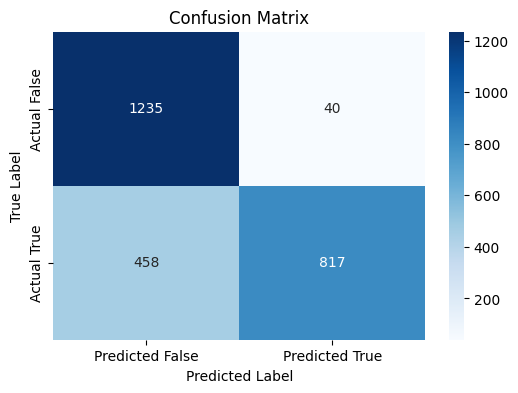

C:\Users\muhit\AppData\Local\Temp\ipykernel_6128\2247158343.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='Blues_d', ax=ax1)


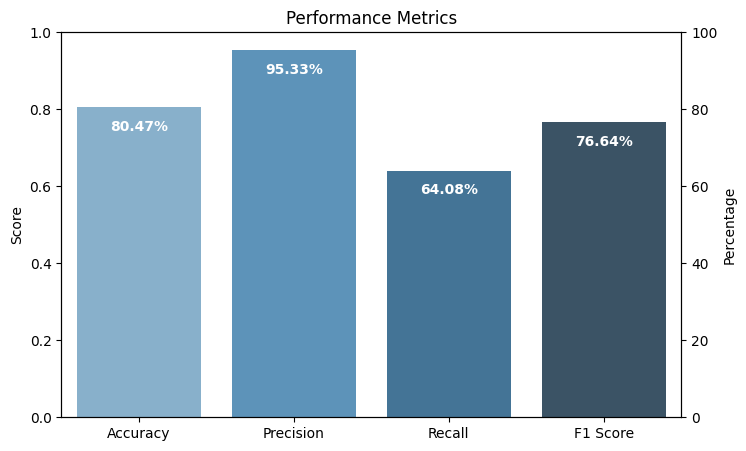

In [15]:
# Visualize the confusion matrix if data exists
if conf_matrix.size > 0:
    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted False', 'Predicted True'], 
                yticklabels=['Actual False', 'Actual True'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Visualize the performance metrics in a bar plot
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    values = [accuracy, precision, recall, f1]
    
    fig, ax1 = plt.subplots(figsize=(8, 5))
    
    sns.barplot(x=metrics, y=values, palette='Blues_d', ax=ax1)
    ax1.set_title('Performance Metrics')
    ax1.set_ylabel('Score')
    ax1.set_ylim(0, 1)  # Since metrics range from 0 to 1
    
    # Create a secondary y-axis to show the percentage
    ax2 = ax1.twinx()
    ax2.set_ylim(0, 100)
    ax2.set_ylabel('Percentage')
    
    # Add percentage labels inside the bars
    for i, value in enumerate(values):
        ax1.text(i, value - 0.05, f'{value:.2%}', ha='center', va='center', color='white', weight='bold')
    
    plt.show()

else:
    print("Confusion matrix is empty.")